### This notebook contains the codes to extract and process the necessary simulation data for constructing the machine learning model. The contents must be incorporated to the resilience_metrics.py once finalized.

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

from IPython.display import clear_output

import os
import pandas as pd
from pathlib import Path
from sklearn import metrics
import statistics
import numpy as np
import copy

import infrarisk.src.network_sim_models.interdependencies as interdependencies
from infrarisk.src.network_sim_models.integrated_network import *

from numba import jit, cuda, numba

In [2]:
network_dir = Path('../../data/networks/micropolis')
water_folder = network_dir/'water/med'
power_folder = network_dir/'power/low'

micropolis_network = IntegratedNetwork(name = 'Micropolis', 
                                       water_folder= water_folder,
                                       power_folder = power_folder,
                                       water_sim_type = 'PDA',
                                       power_sim_type='1ph')

Water network successfully loaded from ..\..\data\networks\micropolis\water\med/water.inp. The analysis type is set to PDA.
initial simulation duration: 60s; hydraulic time step: 60s; pattern time step: 3600s

Power system successfully loaded from ..\..\data\networks\micropolis\power\low\power.json. Single phase power flow simulation will be used.



In [3]:
link_criticality_measures = pd.read_csv(f"{network_dir}/link_criticality_features.csv", sep = ",")
link_criticality_measures.head()

,source,target,id,link_type,betweenness_centrality,cluster_num,katz_centrality,maxflow,length,link_category,degree_centrality,eigenvector_centrality,closeness_centrality,cluster
0,P_B0,P_B1,P_L1,Power,0.082426,7,-0.027746,18.058576,100.363,Power line,0.005719,3.399758e-17,0.000737,power7
1,P_B0,P_B79,P_L394,Power,0.057579,2,-0.043812,0.662464,56.033,Power line,0.005719,1.081720e-17,0.000724,power2
2,P_B1,P_B2,P_L2,Power,0.064377,7,0.013581,17.638314,183.230,Power line,0.004902,3.457825e-17,0.000756,power7
3,P_B2,P_B3,P_L3,Power,0.080543,7,0.001400,16.372524,199.139,Power line,0.004902,4.053703e-18,0.000780,power7
4,P_B3,P_B4,P_L4,Power,0.091090,7,-0.029408,15.137651,165.686,Power line,0.004902,-1.699627e-17,0.000802,power7


In [4]:
# Set scenarios folder
#folder = Path('../../data/networks/micropolis/scenarios')
folder = Path("E:/dreaminsg data")
scenarios = [f for f in sorted(os.listdir(folder)) if f.startswith("flood")]

#list of recovery strategies to be considered
#strategies = ['capacity', 'centrality', 'crewdist', 'zone']
strategies = ['capacity', 'zone', 'centrality']

#create the empty dataframe for ML dataset

columns = ["scenario", "strategy", 'water_perf_ecs', 'water_perf_pcs', 'power_perf_ecs',
        'power_perf_pcs', "all_compons"] + list(link_criticality_measures.cluster.unique())
        
ml_df = pd.DataFrame(columns = columns)

abnormal_results = []

junc_list = micropolis_network.wn.junction_name_list
base_water_demands = micropolis_network.base_water_node_supply
base_power_demands = micropolis_network.base_power_supply


In [5]:
for index, scenario in enumerate(scenarios):
    print(index,"/",len(scenarios), ". ", scenario)

    ml_df_new = dict()
    for key in columns:
        if key == 'scenario':
            ml_df_new[key] = scenario
        elif key in ["strategy", 'water_perf_ecs', 'water_perf_pcs', 'power_perf_ecs', 'power_perf_pcs']:
            ml_df_new[key] = None
        else:
            ml_df_new[key] = 0
    
    disruption_file = pd.read_csv(f"{folder}/{scenario}/disruption_file.csv")
    ml_df_new["all_compons"] = disruption_file.shape[0]
    for _, row in disruption_file.iterrows():
        if row['components'] in link_criticality_measures['id'].to_list():
            cluster = link_criticality_measures[link_criticality_measures["id"] == row['components']].cluster.item()
            ml_df_new[cluster] += 1
        else:
            print(f"Component type not detectable ({row['components']}).")            
    
    for strategy in strategies:
        ml_df_new['strategy'] = strategy
        water_demands_file = f"{folder}/{scenario}/{strategy}/water_junc_demand.csv"
        power_demands_file = f"{folder}/{scenario}/{strategy}/power_load_demand.csv"
        water_pressure_file = f"{folder}/{scenario}/{strategy}/water_node_pressure.csv"
        
        if os.path.isfile(water_demands_file):
            water_demands = pd.read_csv(water_demands_file, sep = "\t")
            water_time_list = water_demands.time/60
            water_time_list = water_time_list.tolist()
            rel_time_list = water_demands['time'] % (24*3600)
            index_list = [int(x/60) for x in rel_time_list]
            water_demands = water_demands[junc_list]
            
            # water_pressures = pd.read_csv(water_pressure_file, sep = "\t")
            # water_pressures = water_pressures[junc_list]
            # water_press_corrections = copy.deepcopy(water_pressures)
            
            power_demands = pd.read_csv(power_demands_file, sep = "\t")
            power_time_list = power_demands.time/60
            power_time_list= power_time_list.tolist()
            
            base_water_demands_new = base_water_demands.iloc[index_list].reset_index(drop=True)
            base_water_demands_new = base_water_demands_new[junc_list]
            
            water_demands_ratio = water_demands/ base_water_demands_new
            water_demands_ratio = water_demands_ratio.clip(upper=1, lower = 0)
            # if not os.path.isfile(f"{folder}/{scenario}/{strategy}/water_demands_ratio.csv"):
            #     water_demands_ratio.to_csv(f"{folder}/{scenario}/{strategy}/water_demands_ratio.csv", index = False)
            
            water_ecs_list = water_demands_ratio.mean(axis = 1, skipna = True).tolist()
            
            if water_ecs_list[-1] < 0.9:
                abnormal_results.append(scenario)
                
            water_pcs_list = pd.concat([water_demands, base_water_demands_new]).min(level=0).sum(axis=1, skipna = True)/base_water_demands_new.sum(axis=1, skipna = True)
            water_pcs_list = water_pcs_list.tolist()

            base_load_demands = pd.DataFrame(base_power_demands.load.p_mw.tolist() + base_power_demands.motor.pn_mech_mw.tolist()).transpose()
            base_load_demands.columns = base_power_demands.load.name.tolist() + base_power_demands.motor.name.tolist()
            base_load_demands = pd.concat([base_load_demands]*(power_demands.shape[0])).reset_index(drop=True)

            power_demand_ratio = power_demands.iloc[:,1:] / base_load_demands
            power_demand_ratio = power_demand_ratio.clip(upper=1, lower  = 0)
            # if not os.path.isfile(f"{folder}/{scenario}/{strategy}/power_demand_ratio.csv"):
            #     power_demand_ratio.to_csv(f"{folder}/{scenario}/{strategy}/power_demand_ratio.csv", index = False)

            power_ecs_list = power_demand_ratio.mean(axis = 1, skipna = True).tolist()
            power_pcs_list = pd.concat([power_demands.iloc[:,1:], base_load_demands]).min(level=0).sum(axis=1, skipna = True)/base_load_demands.sum(axis=1, skipna = True)
            power_pcs_list = power_pcs_list.tolist()
            
            
            ml_df_new['water_perf_ecs'] = round(metrics.auc(water_time_list, [1 - x for x in water_ecs_list]), 3)/60 #Equivalent outage hours
            ml_df_new['water_perf_pcs'] = round(metrics.auc(water_time_list, [1 - x for x in water_pcs_list]), 3)/60
            ml_df_new['power_perf_ecs'] = round(metrics.auc(power_time_list, [1 - x for x in power_ecs_list]), 3)/60
            ml_df_new['power_perf_pcs'] = round(metrics.auc(power_time_list, [1 - x for x in power_pcs_list]), 3)/60
            
            power_auc_df = pd.DataFrame(data = {'time': power_time_list, 
                                                'ecs': power_ecs_list, 
                                                'pcs': power_pcs_list})
            power_auc_df.to_csv(f"{folder}/{scenario}/{strategy}/power_auc.csv", index = False)
            
            water_auc_df = pd.DataFrame(data = {'time': water_time_list, 
                                                'ecs': water_ecs_list, 
                                                'pcs': water_pcs_list})
            water_auc_df.to_csv(f"{folder}/{scenario}/{strategy}/water_auc.csv", index = False)
            
            ml_df = ml_df.append(ml_df_new, ignore_index=True)
            print(ml_df.iloc[-1,:].tolist())
            
        else:
            pass
    clear_output(wait=True)
    
abnormal_results = list(set(abnormal_results))

3 / 164 .  flood100
['flood100', 'capacity', 5e-05, 0.00011666666666666667, 0.47546666666666665, 0.30551666666666666, 5, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
['flood100', 'zone', 5e-05, 0.0001, 0.5082666666666666, 0.32658333333333334, 5, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]


In [7]:
ml_df['ecs_auc'] = ml_df['water_perf_ecs']*0.5 + ml_df['power_perf_ecs']*0.5
ml_df['pcs_auc'] = ml_df['water_perf_pcs']*0.5 + ml_df['power_perf_pcs']*0.5
ml_df.shape

(489, 33)

In [4]:
#ml_df.to_csv("auc_df_tracks.csv", index = False, sep = ",")
ml_df2 = pd.read_csv("auc_df_tracks.csv", sep = ',')
ml_df2.shape

(489, 33)

<AxesSubplot:>

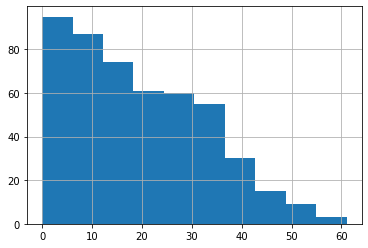

In [6]:
ml_df2['pcs_auc'].hist()

In [7]:
ml_df2[ml_df2['pcs_auc'] > 80]

,scenario,strategy,water_perf_ecs,water_perf_pcs,power_perf_ecs,power_perf_pcs,all_compons,power7,power2,power1,...,transpo8,transpo3,transpo5,transpo0,transpo4,transpo2,transpo6,transpo1,ecs_auc,pcs_auc


In [5]:
ml_df2 = ml_df2[ml_df2['pcs_auc'] < 80]

Text(0.5, 1.0, 'Histogram of resilience metrics')

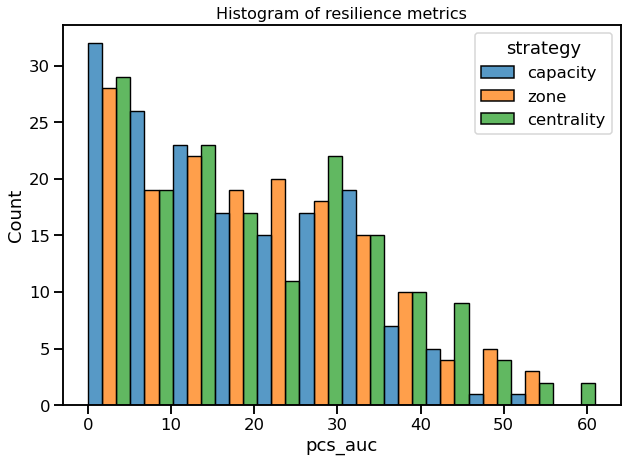

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.set_context('talk')
fig = plt.figure(figsize = (10,7))
ax = sns.histplot(x= 'pcs_auc', hue = 'strategy', stat="count", multiple="dodge",  data = ml_df2, palette=("tab10"))

# ax = sns.kdeplot(data=ml_df, x="pcs_auc", hue="strategy", cumulative=True, common_norm=False, common_grid=True,)

ax.set_title('Histogram of resilience metrics', size = 16)

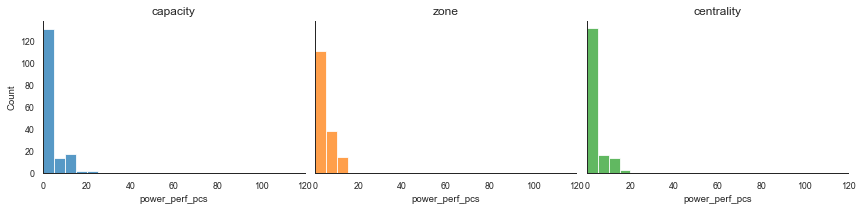

In [22]:

sns.set_theme(style="white")
sns.set_context('paper')
g = sns.FacetGrid(ml_df2, hue = 'strategy', col='strategy', col_wrap=3, palette="tab10", height=3, aspect= 1.33 )
#g = (g.map(sns.kdeplot, "power_perf_pcs"))
(g.map(sns.histplot, "power_perf_pcs", stat = 'count', binwidth = 5))
g.set_titles(col_template="{col_name}", fontweight='regular', size=12)
g.set(xlim=(0, 120))

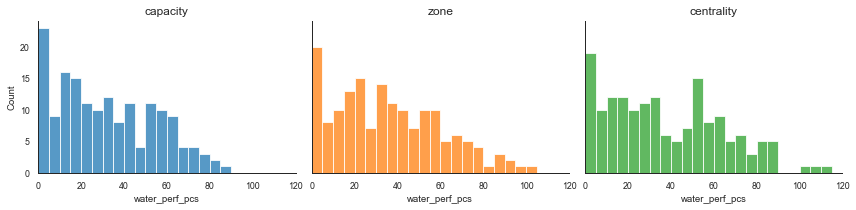

In [21]:
sns.set_theme(style="white")
sns.set_context('paper')
g = sns.FacetGrid(ml_df2, hue = 'strategy', col='strategy', col_wrap=3, palette="tab10", height=3, aspect= 1.33 )
#g = (g.map(sns.kdeplot, "power_perf_pcs"))
(g.map(sns.histplot, f"water_perf_pcs", stat = 'count', binwidth = 5))
g.set_titles(col_template="{col_name}", fontweight='regular', size=12)
g.set(xlim=(0, 120))

In [6]:
infra = "power"
y = f"{infra}_perf_pcs"
ml_df_wide = ml_df2[['scenario', 'strategy', y]].pivot(index='scenario', columns='strategy', values=y)
ml_df_wide = ml_df_wide.dropna()
ml_df_wide.head()


strategy,capacity,centrality,zone
scenario,,,
flood0,0.632933,0.632933,0.818417
flood1,1.500867,2.019200,1.043383
flood10,2.333483,2.402400,3.720750
flood100,0.305517,0.305517,0.326583
flood101,0.063800,0.063800,0.063800


In [13]:
unique_full_scenarios = ml_df_wide.index.tolist()

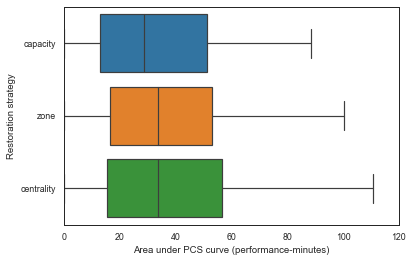

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize = (6,4))
sns.plotting_context("poster")

ax = sns.boxplot(y='strategy', x="water_perf_pcs", data=ml_df2, orient="h", palette = 'tab10')
ax.set_xlabel(f"Area under PCS curve (performance-minutes)")
ax.set_ylabel(f"Restoration strategy")
#ax.set_title(f"Comparison of effectiveness of {infra} restoration strategies")
ax.set_xlim((0, 120))
plt.show()

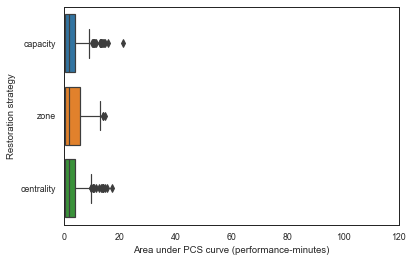

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize = (6,4))
sns.plotting_context("poster")
ax = sns.boxplot(y='strategy', x="power_perf_pcs", data=ml_df2, orient="h", palette = 'tab10')
ax.set_xlabel(f"Area under PCS curve (performance-minutes)")
ax.set_ylabel(f"Restoration strategy")
#ax.set_title(f"Comparison of effectiveness of {infra} restoration strategies")
ax.set_xlim((0, 120))
plt.show()

In [15]:
ml_df2.head()

,scenario,strategy,water_perf_ecs,water_perf_pcs,power_perf_ecs,power_perf_pcs,all_compons,power7,power2,power1,...,transpo8,transpo3,transpo5,transpo0,transpo4,transpo2,transpo6,transpo1,ecs_auc,pcs_auc
0,flood0,capacity,52.460567,53.473617,0.587383,0.632933,21,0,0,0,...,0,1,2,0,0,0,1,0,26.523975,27.053275
1,flood0,zone,41.880450,42.243067,1.105750,0.818417,21,0,0,0,...,0,1,2,0,0,0,1,0,21.493100,21.530742
2,flood0,centrality,38.986100,39.363633,0.587383,0.632933,21,0,0,0,...,0,1,2,0,0,0,1,0,19.786742,19.998283
3,flood1,capacity,53.969967,55.164350,1.734583,1.500867,21,0,0,0,...,0,0,4,0,0,1,1,0,27.852275,28.332608
4,flood1,zone,50.862600,52.026200,1.355050,1.043383,21,0,0,0,...,0,0,4,0,0,1,1,0,26.108825,26.534792


In [16]:
y

'power_perf_pcs'

In [8]:
#!pip install pingouin
import pingouin as pg

In [17]:

res = pg.rm_anova(dv=y, within='strategy', subject='scenario', data=ml_df2, detailed=True)
res

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,strategy,10.867418,2,5.433709,2.679902,0.07009,0.08817,0.016273,0.716331,False,0.603998,2.362385e-18
1,Error,656.935038,324,2.027577,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# install pingouin as !pip install pingouin
# make sure you have installed the pingouin package (pip install pingouin)
ml_df_full = ml_df2[ml_df2.scenario.isin(unique_full_scenarios)]
post_hocs = pg.pairwise_ttests(dv=y, within='strategy', subject='scenario', padjust='fdr_bh', data=ml_df_full)
post_hocs[['Contrast', 'A', 'B', 'T', 'p-corr']]

NameError: name 'unique_full_scenarios' is not defined

In [12]:
ml_df2.head()

,scenario,strategy,water_perf_ecs,water_perf_pcs,power_perf_ecs,power_perf_pcs,all_compons,power7,power2,power1,...,transpo8,transpo3,transpo5,transpo0,transpo4,transpo2,transpo6,transpo1,ecs_auc,pcs_auc
0,flood0,capacity,52.460567,53.473617,0.587383,0.632933,21,0,0,0,...,0,1,2,0,0,0,1,0,26.523975,27.053275
1,flood0,zone,41.880450,42.243067,1.105750,0.818417,21,0,0,0,...,0,1,2,0,0,0,1,0,21.493100,21.530742
2,flood0,centrality,38.986100,39.363633,0.587383,0.632933,21,0,0,0,...,0,1,2,0,0,0,1,0,19.786742,19.998283
3,flood1,capacity,53.969967,55.164350,1.734583,1.500867,21,0,0,0,...,0,0,4,0,0,1,1,0,27.852275,28.332608
4,flood1,zone,50.862600,52.026200,1.355050,1.043383,21,0,0,0,...,0,0,4,0,0,1,1,0,26.108825,26.534792


In [13]:
pg.pairwise_gameshowell(data=ml_df2, dv=y,
                        between='strategy').round(3)

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,capacity,centrality,3.173,3.137,0.036,0.454,0.079,323.180,0.900,0.009
1,capacity,zone,3.173,3.469,-0.297,0.435,-0.682,317.328,0.754,-0.075
2,centrality,zone,3.137,3.469,-0.333,0.423,-0.787,321.082,0.694,-0.087


In [19]:
37.884596- 35.719429

2.165167000000004

In [67]:
ml_df_wide.describe()

strategy,capacity,centrality,zone
count,163.000000,163.000000,163.000000
mean,3.172717,3.136641,3.469371
std,4.200549,3.994035,3.629832
min,0.000000,0.000000,0.000000
25%,0.310675,0.331300,0.468158
50%,1.785783,1.803083,1.854767
75%,4.065492,4.100117,5.643475
max,21.323800,17.110883,14.806200


In [70]:
3.136641 - 3.469371

-0.3327300000000002

In [114]:
import pingouin as pg
pg.sphericity(data=ml_df, dv=y, subject='scenario', within='strategy')[-1]

0.09258700303649628

In [59]:
pg.normality(data=ml_df, dv=y, group='strategy')

,W,pval,normal
capacity,0.950096,0.000015,False
zone,0.961030,0.000156,False
centrality,0.955144,0.000043,False


In [117]:
ml_df_wide.describe().iloc[1,0] - ml_df_wide.describe().iloc[1,1]

-206.89464417177942

In [118]:
ml_df_wide.describe().iloc[1,0] - ml_df_wide.describe().iloc[1,2]

11.40042944785182

In [119]:
ml_df_wide.describe().iloc[1,1] - ml_df_wide.describe().iloc[1,2]

218.29507361963124

In [45]:
import numpy as np
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.linear_model import LinearRegression

In [40]:
ml_df2.columns

Index(['scenario', 'strategy', 'water_perf_ecs', 'water_perf_pcs',
       'power_perf_ecs', 'power_perf_pcs', 'all_compons', 'power7', 'power2',
       'power1', 'power0', 'power5', 'power6', 'power4', 'power3', 'water5',
       'water1', 'water2', 'water6', 'water3', 'water0', 'water4', 'transpo7',
       'transpo8', 'transpo3', 'transpo5', 'transpo0', 'transpo4', 'transpo2',
       'transpo6', 'transpo1', 'ecs_auc', 'pcs_auc'],
      dtype='object')

In [62]:
dep_var = 'pcs_auc'

features = ml_df2[['strategy', 'power4', 'power3',
       'power5', 'power2', 'power1', 'power6', 'power0', 'power7', 'water1',
       'water4', 'water0', 'water5', 'water2', 'water3', 'water6', 'transpo7',
       'transpo2', 'transpo5', 'transpo1', 'transpo3', 'transpo4', 'transpo0',
       'transpo6', dep_var]]

In [63]:
features = features.replace('nan',np.NaN)
features = features.dropna()

labels = np.array(features[dep_var])
del features[dep_var]
features = pd.get_dummies(features)

feature_list = list(features.columns)
features = np.array(features)

# Decision Tree Model

In [87]:
clf = ExtraTreesRegressor(n_estimators=500)
clf = clf.fit(features, labels)

print(feature_list)
print(clf.feature_importances_)

pd.DataFrame(data = {'features': feature_list,
                     'feature importance': clf.feature_importances_}).sort_values(by='feature importance', ascending=False)

['power4', 'power3', 'power5', 'power2', 'power1', 'power6', 'power0', 'power7', 'water1', 'water4', 'water0', 'water5', 'water2', 'water3', 'water6', 'transpo7', 'transpo2', 'transpo5', 'transpo1', 'transpo3', 'transpo4', 'transpo0', 'transpo6', 'strategy_capacity', 'strategy_centrality', 'strategy_zone']
[0.012 0.037 0.043 0.016 0.034 0.015 0.023 0.022 0.243 0.022 0.053 0.026 0.076 0.036 0.033 0.021 0.075 0.01  0.017 0.056 0.015 0.045 0.021 0.015 0.017 0.018]


,features,feature importance
8,water1,0.242529
12,water2,0.076338
16,transpo2,0.074579
19,transpo3,0.056149
10,water0,0.053134
21,transpo0,0.045477
2,power5,0.042821
1,power3,0.036881
13,water3,0.035631
4,power1,0.033826


In [65]:
from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (409, 26)
Training Labels Shape: (409,)
Testing Features Shape: (137, 26)
Testing Labels Shape: (137,)


In [66]:
model = SelectFromModel(clf, prefit=True, threshold = '0.5*median')
features_new = model.transform(features)
features_new.shape

(546, 25)

In [67]:
model = SelectFromModel(clf, prefit=True, threshold = '0.5*median')
features_new = model.transform(features)
features_new.shape

(546, 25)

In [68]:
feature_list_new = []

for i, feature in enumerate(feature_list):
    if model.get_support()[i]:
        feature_list_new.append(feature)

feature_list_new

['power4',
 'power3',
 'power5',
 'power2',
 'power1',
 'power6',
 'power0',
 'power7',
 'water1',
 'water4',
 'water0',
 'water5',
 'water2',
 'water3',
 'water6',
 'transpo7',
 'transpo2',
 'transpo1',
 'transpo3',
 'transpo4',
 'transpo0',
 'transpo6',
 'strategy_capacity',
 'strategy_centrality',
 'strategy_zone']

In [69]:
train_features, test_features, train_labels, test_labels = train_test_split(features_new, labels, test_size = 0.25, random_state = 43)
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (409, 25)
Training Labels Shape: (409,)
Testing Features Shape: (137, 25)
Testing Labels Shape: (137,)


In [70]:
parameters = {'max_depth':range(2,10), 'min_samples_leaf': range(3,10)}
clf = GridSearchCV(tree.DecisionTreeRegressor(), parameters, n_jobs=5, scoring = 'accuracy')
clf.fit(X=features, y=labels)
tree_model = clf.best_estimator_
print (clf.best_score_, clf.best_params_) 

nan {'max_depth': 2, 'min_samples_leaf': 3}


In [71]:
clf = tree.DecisionTreeRegressor(max_depth = 2, random_state = 0, min_samples_leaf=3)
# Train the model on training data
clf.fit(features, labels)

DecisionTreeRegressor(max_depth=2, min_samples_leaf=3, random_state=0)

In [72]:
y_pred=clf.predict(features)   

def measure_performance(y_test, y_pred, X_train):
    from sklearn.metrics import mean_squared_error, r2_score 

    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    r2 = r2_score(y_test,y_pred)

    # Scikit-learn doesn't have adjusted r-square, hence custom code
    n = y_pred.shape[0]
    k = X_train.shape[1]
    adj_r_sq = 1 - (1 - r2)*(n-1)/(n-1-k)

    print(rmse, r2, adj_r_sq)
    
        
measure_performance(labels,y_pred, features)

754.1439263650936 0.4936469792964451 0.4682805466600435


# Random Forest Model

In [76]:
for i in [1, 10, 20, 50, 100, 500, 1000]:
    regressor = RandomForestRegressor(n_estimators = i, random_state = 4)
    regressor.fit(features, labels)
    y_pred = regressor.predict(features)
    print("n_estimators: ", i, "- Accuracy: ", regressor.score(features, labels))

n_estimators:  1 - Accuracy:  0.8279389353617099
n_estimators:  10 - Accuracy:  0.9717836221196546
n_estimators:  20 - Accuracy:  0.9738980766826878
n_estimators:  50 - Accuracy:  0.9769715849824435
n_estimators:  100 - Accuracy:  0.979934725270522
n_estimators:  500 - Accuracy:  0.980909486895834
n_estimators:  1000 - Accuracy:  0.9809600953338314


In [77]:
# Evaluating the Algorithm
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(labels, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(labels, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(labels, y_pred)))

Mean Absolute Error: 80.62151046019747
Mean Squared Error: 21385.521231241135
Root Mean Squared Error: 146.23789259710063


In [78]:
measure_performance(labels,y_pred, features)

146.23789259710063 0.9809600953338314 0.9800062658129829


# Linear Regression

In [79]:
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(train_features, train_labels)  # perform linear regression
y_pred = linear_regressor.predict(train_features)  # make predictions

In [80]:
print(feature_list_new)
print(linear_regressor.coef_)

['power4', 'power3', 'power5', 'power2', 'power1', 'power6', 'power0', 'power7', 'water1', 'water4', 'water0', 'water5', 'water2', 'water3', 'water6', 'transpo7', 'transpo2', 'transpo1', 'transpo3', 'transpo4', 'transpo0', 'transpo6', 'strategy_capacity', 'strategy_centrality', 'strategy_zone']
[  65.202  -28.86   140.027   23.571   70.132   41.646   67.958  500.296  112.454  268.097  185.466   35.729   80.603  102.16   100.421  135.93   575.572  173.385  149.931  -71.349  156.587   25.471 -133.583   88.132   45.452]


In [81]:
linear_regressor.score(train_features, train_labels, sample_weight=None)

0.6959630063626636

# Performance Plots

In [82]:
# Set scenarios folder
folder = Path('../../data/networks/micropolis/scenarios')
scenarios = [f for f in sorted(os.listdir(folder))]
scenarios = [scenario for scenario in scenarios if scenario.startswith('flood')]

#list of recovery strategies to be considered
strategies = ['capacity', 'zone', 'centrality']


junc_list = micropolis_network.wn.junction_name_list
base_water_demands = micropolis_network.base_water_node_supply
base_power_demands = micropolis_network.base_power_supply

In [83]:
columns = ['scenario', 'strategy', 'time', 'perf' , 'compon_count']

water_df = pd.DataFrame(columns = columns)
power_df = pd.DataFrame(columns = columns)

In [84]:

for index, scenario in enumerate(scenarios):
    print(index,"/",len(scenarios), ". ", scenario)
    
    # Load scenario
    disruption_file = pd.read_csv(f"{folder}/{scenario}/disruption_file.csv")
    water_compon_count = len([compon for compon in disruption_file.components if compon.startswith("W_")] )   
    power_compon_count = len([compon for compon in disruption_file.components if compon.startswith("P_")] )       
    
    for strategy in strategies:  
        water_demands_file = f"{folder}/{scenario}/{strategy}/water_junc_demand.csv"
        power_demands_file = f"{folder}/{scenario}/{strategy}/power_load_demand.csv"
        
        if os.path.isfile(water_demands_file):
            water_demands = pd.read_csv(water_demands_file, sep = "\t")
            water_time_list = water_demands.time/60
            water_time_list = water_time_list.tolist()
            rel_time_list = water_demands['time'] % (24*3600)
            index_list = [int(x/60) for x in rel_time_list]
            water_demands = water_demands[junc_list]
            
            power_demands = pd.read_csv(power_demands_file, sep = "\t")
            power_time_list = power_demands.time/60
            power_time_list= power_time_list.tolist()
            
            base_water_demands_new = base_water_demands.iloc[index_list].reset_index(drop=True)
            base_water_demands_new = base_water_demands_new[junc_list]
            
            water_demands_ratio = water_demands/ base_water_demands_new
            water_demands_ratio = water_demands_ratio.clip(upper=1)
                
            water_pcs_list = pd.concat([water_demands, base_water_demands_new]).min(level=0).sum(axis=1, skipna = True)/base_water_demands_new.sum(axis=1, skipna = True)
            water_pcs_list = water_pcs_list.tolist()

            base_load_demands = pd.DataFrame(base_power_demands.load.p_mw.tolist() + base_power_demands.motor.pn_mech_mw.tolist()).transpose()
            base_load_demands.columns = base_power_demands.load.name.tolist() + base_power_demands.motor.name.tolist()
            base_load_demands = pd.concat([base_load_demands]*(power_demands.shape[0])).reset_index(drop=True)

            power_demand_ratio = power_demands.iloc[:,1:] / base_load_demands
            power_demand_ratio = power_demand_ratio.clip(upper=1)

            #power_ecs_list = power_demand_ratio.mean(axis = 1, skipna = True).tolist()
            power_pcs_list = pd.concat([power_demands.iloc[:,1:], base_load_demands]).min(level=0).sum(axis=1, skipna = True)/base_load_demands.sum(axis=1, skipna = True)
            power_pcs_list = power_pcs_list.tolist()
            
            
            power_df_new = pd.DataFrame(data = {'scenario': [scenario]*len(power_time_list),
                                                'strategy': [strategy]*len(power_time_list),
                                                'time': power_time_list, 
                                                'perf': power_pcs_list,
                                                'compon_count': [power_compon_count]*len(power_time_list)})
            
            water_df_new = pd.DataFrame(data = {'scenario': [scenario]*len(water_time_list),
                                                'strategy': [strategy]*len(water_time_list),
                                                'time': water_time_list, 
                                                'perf': water_pcs_list,
                                                'compon_count': [water_compon_count]*len(water_time_list)})
            
            water_df = water_df.append(water_df_new, ignore_index=True)
            #water_df.time = water_df.time/60
            power_df = power_df.append(power_df_new, ignore_index=True)
            #power_df.time = power_df.time/60
            
        else:
            pass
    clear_output(wait=True)

In [85]:
water_df

,scenario,strategy,time,perf,compon_count


In [69]:
water_df.to_csv("../../data/networks/micropolis/flood_water_perf_df.csv", index = False)
power_df.to_csv("../../data/networks/micropolis/flood_power_perf_df.csv", index = False)

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize = (10,7))
ax = sns.relplot(
    data=water_df,
    x="time", y="perf",
    size=1, col="strategy",
    kind="line", palette='Greys',
    height=5, aspect=.75, facet_kws=dict(sharex=False),
)
ax.set_xlabel(f"Time in hours")
ax.set_ylabel(f"Measure of Performance")
#ax.set_title(f"Comparison of effectiveness of {infra} restoration strategies")
#ax.set_xlim((0, 5000))
plt.show()